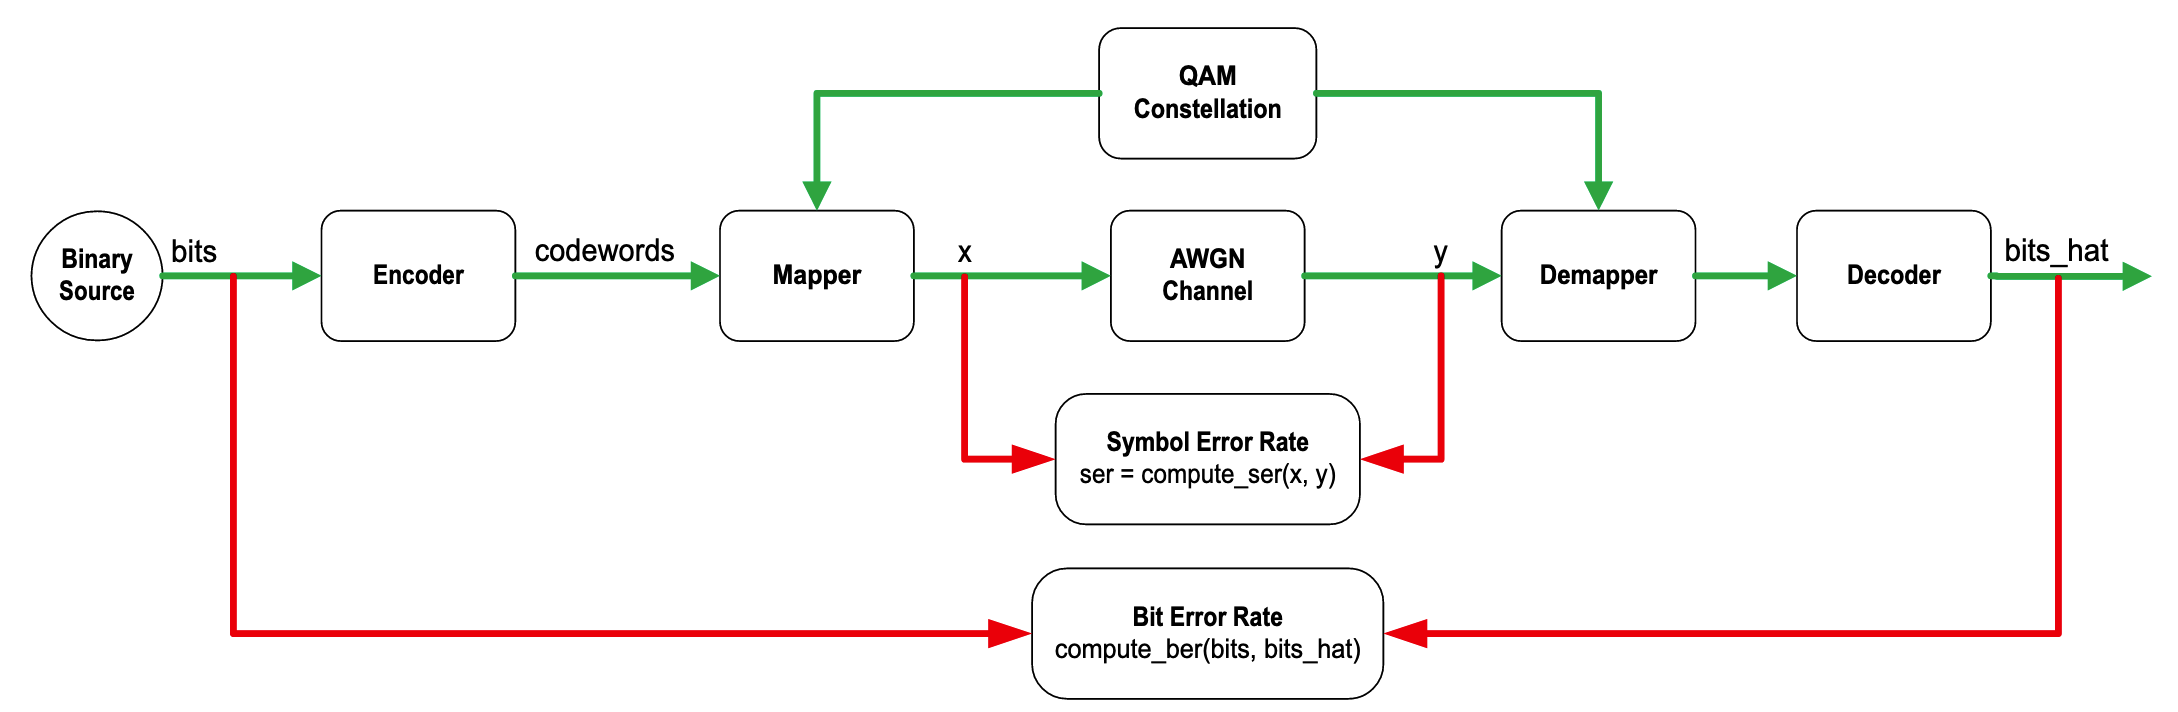

2023-03-22 15:47:09.972898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 15:47:15.218653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


bers_UncodedSystem:
 [0.36213086 0.34293164 0.32381641 0.29959766 0.27748633 0.25286328
 0.22686328 0.20162109 0.17761328 0.15351953 0.13028906 0.10620508
 0.08514648 0.06388086 0.04596484 0.0302793  0.01851758 0.010125
 0.00460547 0.00178711]
bers_CodedSystem:
 [0.42908984 0.41791602 0.40589648 0.39285352 0.37676367 0.36218359
 0.34170898 0.32118945 0.29705469 0.26969141 0.23773633 0.19602734
 0.11844922 0.02157031 0.00067578 0.         0.         0.
 0.         0.        ]
sers_UnodedSystem:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
sers_CodedSystem:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


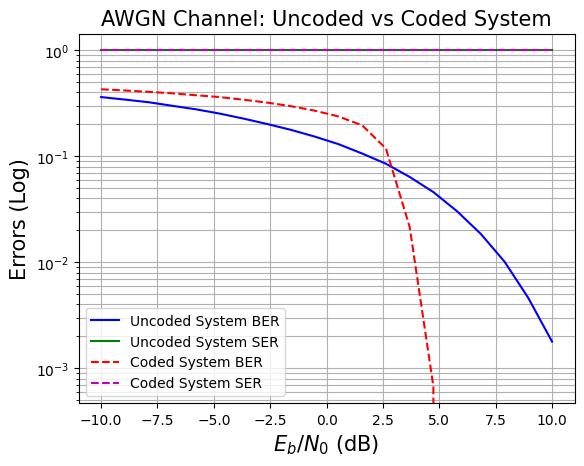

In [1]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

# LDPC Encoder
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder, hard_out=True)

snrs = []
bers_UncodedSystem = []
sers_UncodedSystem = []
bers_CodedSystem = []
sers_CodedSystem = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no_UncodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
    
    no_CodedSystem = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=CODERATE) # Coderate set to 1 as we do uncoded transmission here

    x_UncodedSystem = mapper(bits)

    y_UncodedSystem = awgn_channel([x_UncodedSystem, no_UncodedSystem])

    llr_UncodedSystem = demapper([y_UncodedSystem, no_UncodedSystem])

    bits_hat_UncodedSystem = hard_decisions(llr_UncodedSystem)

    ber_UncodedSystem = compute_ber(bits, bits_hat_UncodedSystem)

    ser_UncodedSystem = compute_ser(x_UncodedSystem, y_UncodedSystem)

    bers_UncodedSystem += [ber_UncodedSystem]
    sers_UncodedSystem += [ser_UncodedSystem]


    codewords = encoder(bits)

    x_CodedSystem = mapper(codewords)
	
    y_CodedSystem = awgn_channel([x_CodedSystem, no_CodedSystem])
	    
    llr_CodedSystem = demapper([y_CodedSystem, no_CodedSystem])
		
    bits_hat_CodedSystem = decoder(llr_CodedSystem)
		    
    ber_CodedSystem = compute_ber(bits, bits_hat_CodedSystem)
			
    ser_CodedSystem = compute_ser(x_CodedSystem, y_CodedSystem)

    bers_CodedSystem += [ber_CodedSystem]
    sers_CodedSystem += [ser_CodedSystem]

print('bers_UncodedSystem:\n',np.transpose(bers_UncodedSystem))
print('bers_CodedSystem:\n',np.transpose(bers_CodedSystem))
print('sers_UnodedSystem:\n',np.transpose(sers_UncodedSystem))
print('sers_CodedSystem:\n',np.transpose(sers_CodedSystem))
title = "AWGN Channel: Uncoded vs Coded System"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "Errors (Log)"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers_UncodedSystem, 'b', label='Uncoded System BER')
plt.semilogy(snrs, sers_UncodedSystem, 'g', label='Uncoded System SER')
plt.semilogy(snrs, bers_CodedSystem, 'r--', label='Coded System BER')
plt.semilogy(snrs, sers_CodedSystem, 'm--', label='Coded System SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()